<center><h1>Pitcher v. Batter</h1></center>
<center><h3>Analyzing the Effect of Pitches and Pitcher on Batter’s Swing Lengths</h3></center>
<center><h4>Kori Thompson</h4></center>

Baseball is often called both the easiest and hardest game to master due to its simplicity of play and deep strategic underpinnings. These strategies range from pre-game decisions like lineup and batting order to in-game situational strategies such as which order of pitches to throw for a given batter. Every at bat and every pitch thrown is calculated to maximize the benefit to the team. All aspects of the game involve a strategy and none more so than the central interactions between the pitcher and the batter. Determining what pitches to throw to prevent a batter from successfully hitting the ball is a key part of a pitching strategy. Can pitchers and their pitches do more than simply outmaneuver a batter? Naturally, the question arises, can the pitcher dictate the batter's swing? If so, to what extent is the swing due to the properties of pitch itself or to the pitcher individually? 

This analysis seeks to answer the question of whether a pitcher can dictate a batter’s swing and to what extent the effect is due to the pitch or the individual pitcher. A batter’s swing was represented by the length of the swing as the sum of movements in x, y, and z-dimensions for this analysis. A number of data points about each pitch were used in the analysis including the velocity of the pitch, the acceleration, the spin axis, the type of pitch, and who was pitching. Several baseline regression models were constructed to predict the length of a batter’s swing. The baseline models included a K-nearest neighbor regression, a decision tree regression, a random forest regression, and a gradient boosted tree regression. The models were then compared and the best-performing baseline model, the gradient boosted tree, was tuned to improve performance. To examine whether the pitcher or the pitch had a greater impact on the batter's swing, the permuted feature importance scores were compared. 

The analysis found that the properties of the pitch were more important in predicting swing lengths than the pitchers themselves. While exploratory data analysis found that there were differences in the average swing lengths against some pitchers, overall the pitcher individually was not important in predicting the length of a swing. Instead, the properties of the pitch were more important in predicting the swing length of a pitch. In particular, the location of the pitch when it crossed the plate from the catcher's perspective. Similarly, the velocity and acceleration of the pitch were found to be important in predicting the swing length. This implies that the pitch's properties do more to dictate the batter's swing than the pitcher individually. The final model was found to explain only about 41.4% of the variance in the batter's swing lengths, suggesting that there are additional factors that likely help in explaining the differences in swing lengths. The analysis may be enhanced by including features that reflect the batter's strategic considerations, such as if a runner was on base or the number of strikes and balls before the pitch. Future research areas may include examining how a batter's stance, location in the batting box, or physical features could affect the batter's swing.


In [8]:
# data processing
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from prettytable import PrettyTable

# data preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import make_pipeline
from scipy.stats import yeojohnson

# models
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

# model evaluation
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

# Data

The data used in this analysis was provided by Statcast for the CSAS 2024 data challenge. In total the dataset consisted of 113 features and 701,557 observations from the entire 2024 MLB spring training, regular season, and post-season. 10 of the features were denoted in the dataset documentation to be deprecated fields from the legacy tracking system and were ignored when loading the dataset. Only the 21 features that are most related to the pitcher, the pitch, or the swing length were considered for the analysis. Records with missing data for either the swing length or the pitch's properties were dropped from the data, leaving a total of 334,905 observations for the analysis. The features were further narrowed down using exploratory data analysis to remove the risk of multicollinearity and features that did not add useful information. The final number of features used in the analysis after feature engineering was 

The swing length was measured as the total movement in the x, y, and z-dimensions from the start of the swing to contact with the ball. The features chosen for the pitcher were the pitcher's ID and the arm the pitch throws with. Regarding the pitch, the data points focused on the location of the pitch when it crossed the plate, the speed, acceleration, and velocity of the pitch, the movement of the pitch, the spin or rotation of the pitch, and the type of pitch thrown. The location of the pitch was measured horizontally and vertically from the catcher's perspective when it crossed the plate, corresponding to plate_x and plate_z respectively. The speed of the pitch was measured at the release of the pitch and the effective speed was derived from the release extension of the pitch. The acceleration of the pitch and the velocity of the pitch were measured in x, y, and z-dimensions, represented by ax, ay, az, vx0, vy0, vz0 respectively. The horizontal and vertical movement of the ball from the catcher's perspective was measured in feet denoted as pfx_x and pfx_z. The pitch's breaking location or the point of descent was measured with gravity in z-dimension as well as from the horizontal point of the pitcher's arm.


In [ ]:
df = pd.read_csv('data/statcast_pitch_swing_data_20240402_20241030_with_arm_angle2.csv')

# drop depreciated columns
df.drop(columns=['spin_dir','umpire','age_pit_legacy', 'age_bat_legacy','sv_id'], inplace=True)
df.drop(columns = df.columns[df.columns.str.endswith('deprecated')], inplace = True)

df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701557 entries, 0 to 701556
Data columns (total 103 columns):
 #    Column                            Dtype  
---   ------                            -----  
 0    pitch_type                        object 
 1    game_date                         object 
 2    release_speed                     float64
 3    release_pos_x                     float64
 4    release_pos_z                     float64
 5    player_name                       object 
 6    batter                            int64  
 7    pitcher                           int64  
 8    events                            object 
 9    description                       object 
 10   zone                              float64
 11   des                               object 
 12   game_type                         object 
 13   stand                             object 
 14   p_throws                          object 
 15   home_team                         object 
 16   away_team         

In [31]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.max_colwidth = 500
df.head(n=5)

pitch_type   game_date  release_speed  release_pos_x  release_pos_z  \
0         FF  2024-04-02           95.0          -2.01           5.22   
1         CH  2024-04-02           88.5          -2.09           4.95   
2         SI  2024-04-02           95.0          -2.02           5.12   
3         KC  2024-04-02           80.8          -3.13           5.61   
4         FF  2024-04-02           95.4          -1.95           5.12   

       player_name  batter  pitcher     events    description  zone  \
0  Rocchio, Brayan  677587   622491     single  hit_into_play   3.0   
1  Rocchio, Brayan  677587   622491        NaN           foul   4.0   
2  Rocchio, Brayan  677587   622491        NaN  called_strike   2.0   
3   Rizzo, Anthony  519203   668678  field_out  hit_into_play  13.0   
4   Hedges, Austin  595978   622491  strikeout       foul_tip   5.0   

                                                                                       des  \
0  Brayan Rocchio singles on a pop up to left fielder Dominic Canzone.   Bo Naylor to 2nd.   
1  Brayan Rocchio singles on a pop up to left fielder Dominic Canzone.   Bo Naylor to 2nd.   
2  Brayan Rocchio singles on a pop up to left fielder Dominic Canzone.   Bo Naylor to 2nd.   
3  Anthony Rizzo grounds out softly, pitcher Zac Gallen to first baseman Christian Walker.   
4                                                 Austin Hedges strikes out on a foul tip.   

  game_type stand p_throws home_team away_team type  hit_location  \
0         R     L        R       SEA       CLE    X           7.0   
1         R     L        R       SEA       CLE    S           NaN   
2         R     L        R       SEA       CLE    S           NaN   
3         R     L        R        AZ       NYY    X           1.0   
4         R     R        R       SEA       CLE    S           2.0   

       bb_type  balls  strikes  game_year  pfx_x  pfx_z  plate_x  plate_z  \
0        popup      0        2       2024  -0.85   1.20     0.69     3.18   
1          NaN      0        1       2024  -1.40   0.07    -0.30     2.29   
2          NaN      0        0       2024  -1.48   0.15    -0.14     3.15   
3  ground_ball      3        2       2024   0.50  -1.10    -1.01     1.13   
4          NaN      1        2       2024  -1.08   0.90    -0.04     2.52   

   on_3b  on_2b     on_1b  outs_when_up  inning inning_topbot    hc_x    hc_y  \
0    NaN    NaN  666310.0             2       6           Top   87.46  125.97   
1    NaN    NaN  666310.0             2       6           Top     NaN     NaN   
2    NaN    NaN  666310.0             2       6           Top     NaN     NaN   
3    NaN    NaN  665742.0             2       6           Top  113.82  188.11   
4    NaN    NaN  666310.0             1       6           Top     NaN     NaN   

        vx0         vy0       vz0         ax         ay         az  sz_top  \
0  8.809589 -138.184461 -2.337745 -12.836936  30.274047 -16.442679    3.10   
1  7.152185 -128.763652 -0.628007 -17.009072  24.589996 -31.420628    3.10   
2  8.099205 -138.195334  0.123694 -20.789685  29.584680 -30.453101    3.09   
3  3.785866 -117.568637 -1.172778   3.876730  23.969148 -42.301623    3.66   
4  7.315465 -138.777335 -3.229775 -15.530020  28.215738 -19.948870    3.18   

   sz_bot  hit_distance_sc  launch_speed  launch_angle  effective_speed  \
0    1.40            180.0          61.9          28.0             93.5   
1    1.40              3.0          69.0         -38.0             87.4   
2    1.39              NaN           NaN           NaN             93.7   
3    1.73              1.0          31.7         -62.0             81.1   
4    1.45              NaN           NaN           NaN             94.3   

   release_spin_rate  release_extension  game_pk  fielder_2  fielder_3  \
0             2061.0                5.4   745273     663728     664034   
1             1677.0                5.4   745273     663728     664034   
2             1832.0                5.5   745273     663728     

## Data Cleaning

Before beginning the analysis, the data was cleaned to remove missing values or unneeded features and to convert any mistyped data. Missing features with more than 5% of values missing were imputed with appropriate values. The missingness of the features was deemed to be either missing at random or missing completely at random. After imputation on the features was completed, instances that still had one or more missing values were dropped from the dataset. Features that were used for data processing, but were not considered for the analysis were dropped before exploratory data analysis was done. 

One of the first things things that was done to process the data was to check for duplicate records. There were no duplicate records found in the dataset implying each record represented a unique pitch in a game and no action was required. We next limited the dataset to a subset of features that were of interest or use for further processing. This included columns related to the pitcher, the pitch, the swing length, or what happened during play. The columns for the description of play, while not of interest for the analysis were left in for use in processing the data and were later dropped. 

In [10]:
df.loc[df.duplicated()]

Empty DataFrame
Columns: [pitch_type, game_date, release_speed, release_pos_x, release_pos_z, player_name, batter, pitcher, events, description, zone, des, game_type, stand, p_throws, home_team, away_team, type, hit_location, bb_type, balls, strikes, game_year, pfx_x, pfx_z, plate_x, plate_z, on_3b, on_2b, on_1b, outs_when_up, inning, inning_topbot, hc_x, hc_y, vx0, vy0, vz0, ax, ay, az, sz_top, sz_bot, hit_distance_sc, launch_speed, launch_angle, effective_speed, release_spin_rate, release_extension, game_pk, fielder_2, fielder_3, fielder_4, fielder_5, fielder_6, fielder_7, fielder_8, fielder_9, release_pos_y, estimated_ba_using_speedangle, estimated_woba_using_speedangle, woba_value, woba_denom, babip_value, iso_value, launch_speed_angle, at_bat_number, pitch_number, pitch_name, home_score, away_score, bat_score, fld_score, post_away_score, post_home_score, post_bat_score, post_fld_score, if_fielding_alignment, of_fielding_alignment, spin_axis, delta_home_win_exp, delta_run_exp, bat_speed, swing_length, estimated_slg_using_speedangle, delta_pitcher_run_exp, hyper_speed, home_score_diff, bat_score_diff, home_win_exp, bat_win_exp, age_pit, age_bat, n_thruorder_pitcher, n_priorpa_thisgame_player_at_bat, pitcher_days_since_prev_game, batter_days_since_prev_game, pitcher_days_until_next_game, batter_days_until_next_game, api_break_z_with_gravity, ...]
Index: []

[0 rows x 103 columns]

In [11]:
# remove columns of no interest
df = df[['release_speed','pitcher','description', 'zone',
         'des','p_throws','pfx_x','pfx_z','plate_x','plate_z','vx0','vy0',
         'vz0', 'ax','ay','az','effective_speed','release_spin_rate',
         'pitch_name','spin_axis','swing_length',
         'api_break_z_with_gravity','api_break_x_arm']]

The data was also inspected for missing values. One trend in the missingness of the data is that many features related to the pitch have the same percentage of missing values, 0.000408. This is assumed to be due to a malfunction in the equipment resulting in no measurements being recorded. There appeared to be no further connection between the missingness of these features and the other features in the dataset. The swing_length feature had about 54% of its values missing. After examining this, it appeared to be due to a combination of no swing taking place and possible equipment malfunction. By looking at the description of the play, we were able to determine whether a swing had occurred and no measurement was recorded or if no swing had taken place. Overall, the missingness of the data in features of interest appears to be either missing completely at random or missing at random. 

In [91]:
df.isna().sum()/len(df)

release_speed               0.000409
pitcher                     0.000000
description                 0.000000
zone                        0.000408
des                         0.000000
p_throws                    0.000000
pfx_x                       0.000408
pfx_z                       0.000408
plate_x                     0.000408
plate_z                     0.000408
vx0                         0.000408
vy0                         0.000408
vz0                         0.000408
ax                          0.000408
ay                          0.000408
az                          0.000408
effective_speed             0.001735
release_spin_rate           0.004654
pitch_name                  0.000406
spin_axis                   0.004651
swing_length                0.540228
api_break_z_with_gravity    0.000415
api_break_x_arm             0.000408
dtype: float64

In particular, the missing values for the swing length appear to be missing at random. After investigating this, there appeared to be no connection between the missing swing lengths and other features. Instead, it was deemed to be due to a combination of the batter not swinging at a pitch and possible equipment malfunctions. Since more than 5% of the values were missing, the decision was made to impute the values. To preserve the instances where no swing was made, no values were imputed for these instances. By definition, the batter does not swing at pitches that are deemed to be balls. It was assumed that no swing was made for a called strike, a pitchout, a blocked ball, or when a batter was hit by a pitch. Based on examination, it was determined that there is a difference in the median swing lengths for a bunt and a regular swing. The median swing length for a bunt is 1.6 feet while the median swing length for a regular swing is 7.2 feet. As such, the imputation for the swings where the ball was hit into play was done by category of regular swing or bunt. Each was imputed with the corresponding median value for its group and the type of event. For example, a foul tip was imputed with the median length of all foul tip swing lengths while a foul bunt was imputed with the median length of all foul bunts. It was assumed that the swings for swinging strikes, fouls, foul tips, and swinging strikes block were regular swings. Likewise missed bunts and foul bunts were assumed to be only bunts and were imputed with the median swing length for that type of bunt.

In [3]:
print(f'Median bunt swing lenght: {df.loc[(df['description']=='hit_into_play') & (df['des'].str.contains('bunt'))]['swing_length'].median(skipna=True)}')
print(f'Median regular hit swing length: {df.loc[(df['description']=='hit_into_play') & (~df['des'].str.contains('bunt'))]['swing_length'].median(skipna=True)}')

Median bunt swing lenght: 1.6
Median regular hit swing length: 7.2


In [12]:
# imput values
df.loc[(df['swing_length'].isna()) & (df['description'] == 'swinging_strike'),'swing_length'] = df.loc[(df['description'] == 'swinging_strike')]['swing_length'].median(skipna=True)
df.loc[(df['swing_length'].isna()) & (df['description']=='foul'),'swing_length'] = df.loc[df['description']=='foul']['swing_length'].median(skipna=True)
# replace swing_length for bunts with NAs with median swing_length for a bunt
df.loc[(df['swing_length'].isna()) & (df['description']=='hit_into_play') & (df['des'].str.contains('bunt')), 'swing_length'] = df.loc[(df['description']=='hit_into_play') & (df['des'].str.contains('bunt'))]['swing_length'].median(skipna=True)
# replace swing_length for regular swings with median swing_length of non-bunts
df.loc[(df['swing_length'].isna()) & (df['description']=='hit_into_play')& (~df['des'].str.contains('bunt')),'swing_length'] = df.loc[(df['description']=='hit_into_play') & (~df['des'].str.contains('bunt'))]['swing_length'].median(skipna=True)
df.loc[(df['swing_length'].isna()) & (df['description']=='foul_tip'),'swing_length'] = df.loc[df['description']=='foul_tip']['swing_length'].median(skipna=True)
df.loc[(df['swing_length'].isna()) & (df['description']=='swinging_strike_blocked'),'swing_length'] = df.loc[df['description']=='swinging_strike_blocked']['swing_length'].median(skipna=True)
df.loc[(df['swing_length'].isna()) & (df['description']=='missed_bunt'),'swing_length'] = df.loc[df['description']=='missed_bunt']['swing_length'].median(skipna=True)
df.loc[(df['swing_length'].isna()) & (df['description']=='foul_bunt'),'swing_length'] = df.loc[df['description']=='foul_bunt']['swing_length'].median(skipna=True)

In [5]:
df.isna().sum()/len(df)

release_speed               0.000409
pitcher                     0.000000
description                 0.000000
zone                        0.000408
des                         0.000000
p_throws                    0.000000
pfx_x                       0.000408
pfx_z                       0.000408
plate_x                     0.000408
plate_z                     0.000408
vx0                         0.000408
vy0                         0.000408
vz0                         0.000408
ax                          0.000408
ay                          0.000408
az                          0.000408
effective_speed             0.001735
release_spin_rate           0.004654
pitch_name                  0.000406
spin_axis                   0.004651
swing_length                0.520139
api_break_z_with_gravity    0.000415
api_break_x_arm             0.000408
dtype: float64

The descriptions of play were not features of interest for the analysis itself and were removed from the set of features for the analysis.The missing values of the features of interest were either missing completely at random or missing at random. Since less than 5% of values were missing, those instances with missing data were dropped. This included instances where no pitch data was gathered as well as instances where the batter did not swing. Since the analysis is interested in the batter's swing rather than in the batter's judgement of whether to swing, it was deemed acceptable to drop these instances. After dropping the missing instances, the dataset contained 334,349 instances.

In [13]:
df = df[['release_speed', 'pitcher', 'zone', 'p_throws','pfx_x',
         'pfx_z','plate_x','plate_z','vx0','vy0','vz0',
         'ax','ay','az','effective_speed','release_spin_rate',
         'pitch_name','spin_axis','swing_length',
         'api_break_z_with_gravity','api_break_x_arm']]

In [14]:
df.dropna(inplace=True)
df.shape

(334905, 21)

The datatypes of the categorical features were convereted to the categorical datatype from the object datatype.

In [15]:
df['zone'] = df['zone'].astype('category')
df['pitch_name'] = df['pitch_name'].astype('category')
df['pitcher'] = df['pitcher'].astype('category')
df['p_throws'] = df['p_throws'].astype('category')

## Exploratory Data Analysis

To explore the data that was considered for the analysis, a combination of descriptive statistics, measure of skew, correlation coefficients, and bivariate charts were used. The mean, standard deviation, minimum, maximum, and quartiles were examined for the numerical features while the frequency of counts was examined for the categorical variables. Instances with extreme outlier values were removed from the dataset to avoid exerting a great influence on the models. The skew was also calculated for the numerical features to check for features with significant departures from normal distributions, which could affect the analysis. Those features with extreme skew and kurtosis values were transformed to make their distributions more normal. Pairplots were used to examine the relationships between the numeric input features and the swing length. Similarly, the correlation coefficients were examined to check for the presence of multicollinearity among the input features. 

The average length of a swing for the season is 7.2 feet with the shortest swing length being 0.3 feet and the longest swing being 12 feet. Swings have a standard deviation of 5.89. The average release speed of a pitch was 89.38 mph with a maximum speed of 105.5. The effective speed was similar with an average speed of 89.68 and a maximum speed of 106.7. The average velocity of a pitch in the x dimension is 2.38, in the y dimension -130.02, and -3.65 in the z dimension. The average acceleration of a pitch in the y dimension was 27.13, -2.03 in the x dimension, and -23.97 in the z dimension. The average pitch crossed the plate at 0.03 in horizontally and at 2.36 vertically. The release spin rate had a large range of values with a minimum spin rate of 9 and a maximum spin rate of 3570.


In [16]:
df.describe().T

count         mean         std         min  \
release_speed             334905.0    89.380346    5.889061   31.900000   
pfx_x                     334905.0    -0.100413    0.889850   -2.480000   
pfx_z                     334905.0     0.606546    0.692984   -1.910000   
plate_x                   334905.0     0.032891    0.598665   -2.820000   
plate_z                   334905.0     2.362103    0.720312   -1.470000   
vx0                       334905.0     2.375419    5.627771  -17.421770   
vy0                       334905.0  -130.024322    8.526748 -153.078880   
vz0                       334905.0    -3.648415    2.534895  -13.817937   
ax                        334905.0    -2.031154   10.868952  -29.024446   
ay                        334905.0    27.127559    3.990450   -8.969443   
az                        334905.0   -23.970027    8.610657  -48.997965   
effective_speed           334905.0    89.675839    6.045070   28.500000   
release_spin_rate         334905.0  2253.509374  366.101850    9.000000   
spin_axis                 334905.0   176.241044   71.266183    0.000000   
swing_length              334905.0     7.208034    1.012312    0.300000   
api_break_z_with_gravity  334905.0     2.288158    1.034306    0.270000   
api_break_x_arm           334905.0     0.341608    0.827780   -2.480000   

                                  25%          50%          75%          max  
release_speed               85.100000    90.200000    94.200000   105.500000  
pfx_x                       -0.860000    -0.160000     0.610000     2.260000  
pfx_z                        0.150000     0.640000     1.210000     2.240000  
plate_x                     -0.380000     0.030000     0.440000     3.070000  
plate_z                      1.870000     2.380000     2.870000     5.550000  
vx0                         -2.024081     4.177136     6.457949    15.866738  
vy0                       -136.937410  -131.192902  -123.871927   -43.668850  
vz0                         -5.371231    -3.746358    -2.032893    14.373622  
ax                         -11.325946    -1.975295     6.504119    27.756152  
ay                          24.152061    27.006133    30.082403   100.050198  
az                         -30.294587   -24.406207   -16.248205    -1.429770  
effective_speed             85.400000    90.500000    94.500000   106.700000  
release_spin_rate         2102.000000  2289.000000  2466.000000  3570.000000  
spin_axis                  129.000000   200.000000   223.000000   360.000000  
swing_length                 6.700000     7.200000     7.900000    12.000000  
api_break_z_with_gravity     1.380000     2.210000     2.960000    24.050000  
api_break_x_arm             -0.300000     0.510000     1.040000     2.230000

The most thrown pitch was a 4-seam fastball which was recorded 107,819 times in the dataset. Rather unsurprisingly, the most common throwing arm for pitchers was the right arm. The most common zone for a pitch to be thrown to was zone 5 or the middle of the strike zone from the catcher's perspective. The top pitcher was pitcher ID 607074 with a recorded 1,643 pitches in the dataset. 

In [17]:
df.describe(include='category').T

count unique              top     freq
pitcher       334905    853           607074     1652
zone        334905.0   13.0              5.0  40512.0
p_throws      334905      2                R   244719
pitch_name    334905     16  4-Seam Fastball   109163

While examining the descriptive statistics of the features, it was noted that the minimum swing length was 0.3 feet. Since the swing length is the sum of all movement in the x, y, and z-dimensions from the start of the swing to connection with the ball, this seemed an improbable number. Similarly, the median swing length of a bunt is 1.6, implying that bunts generally have at least one foot of movement before making contact with the ball. As such swings with abnormally short swing lengths, those less than one foot, were dropped from the dataset. While the longest swing was also noted to be quite far from the average swing length, those swings with abnormally long swing lengths were considered to be accurate observations and were left in the dataset.  

In [18]:
df = df.loc[df['swing_length']> 1]

In [19]:
df.skew(numeric_only=True)

release_speed              -0.682709
pfx_x                       0.168970
pfx_z                      -0.521233
plate_x                     0.047202
plate_z                    -0.148148
vx0                        -0.776287
vy0                         0.698742
vz0                         0.433102
ax                          0.137423
ay                          0.029742
az                         -0.148185
effective_speed            -0.718048
release_spin_rate          -1.096963
spin_axis                  -0.354784
swing_length               -1.292547
api_break_z_with_gravity    0.963795
api_break_x_arm            -0.452196
dtype: float64

Based on the skew values both swing_length and release_spin_rate significantly skewed with values less than -1. Since the general point of concern for skew is above 1 or below -1, these values were transformed to have more normal distributions. A cube transformation was used to reduce the left skew of the swing_lengths. This brought the distribution much closer to a normal distribution with a slight right tail. A Yeo-Johnson transformation which is similar to a Box-Cox transformation was used to reduce the left skew of the release_spin_rate. This also resulted in a more normal distribution with a slight right tail. The untransformed features were then dropped from the dataset in favor of their transformed counterparts.

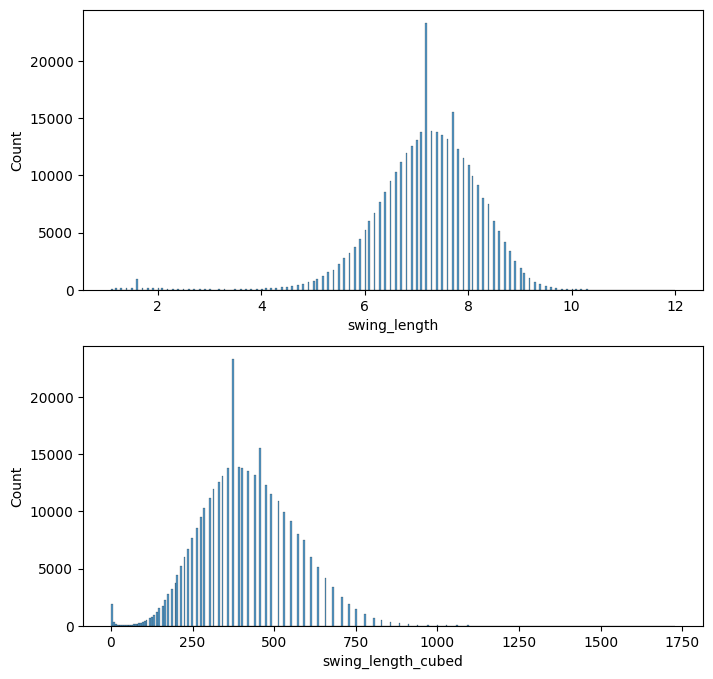

In [32]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (8,8))
sns.histplot(data=df, x='swing_length', ax=ax[0])
# transform variable
df['swing_length_cubed'] = df['swing_length']**3
sns.histplot(data=df, x='swing_length_cubed', ax=ax[1])
plt.show()

df.drop(columns=['swing_length'],inplace=True)

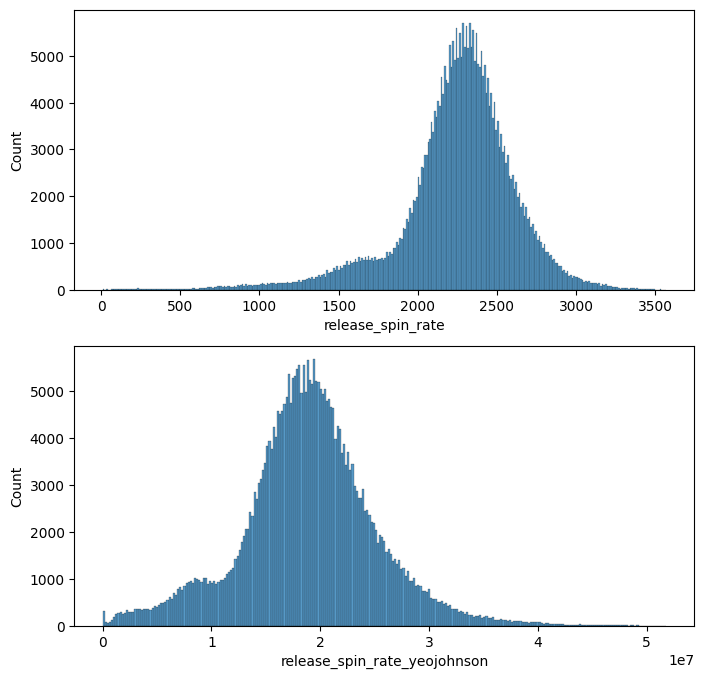

In [33]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (8,8))
sns.histplot(data=df, x='release_spin_rate', ax=ax[0])
# transform variable
df['release_spin_rate_yeojohnson'],_ = yeojohnson(df['release_spin_rate'])
sns.histplot(df, x='release_spin_rate_yeojohnson', ax=ax[1])
plt.show()

df.drop(columns=['release_spin_rate'],inplace=True)

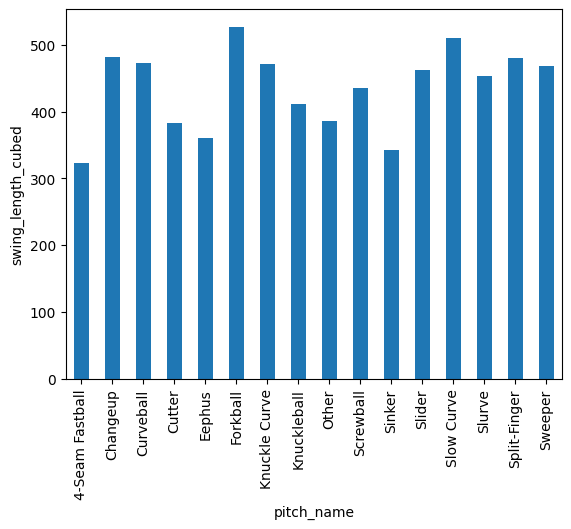

In [34]:
df.groupby('pitch_name', observed=False)['swing_length_cubed'].mean().plot(kind='bar', ylabel='swing_length_cubed')
plt.show()

It can be seen that certain pitches have significantly different average swing lengths against them. Fastballs have the shortest average swing length while forkballs have the longest average swing length. Sinkers also have a shorter average swing length against them than other pitchs. This may imply that some aspect of the type of pitch effects the length of the swing such as fastballs arriving faster making swing lenghts shorter.  

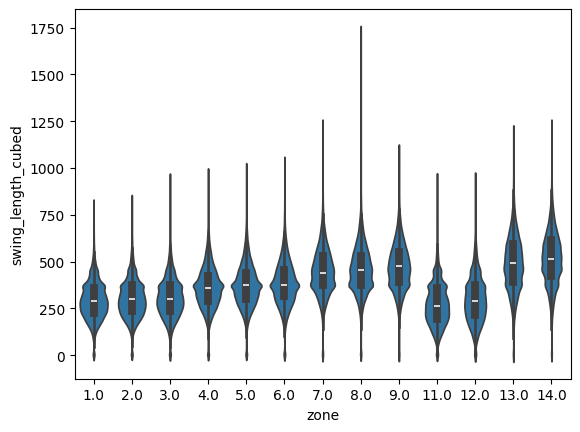

In [35]:
sns.violinplot(data=df, x='zone', y='swing_length_cubed')
plt.show()

Zones 1, 2, and 3 appear to have similar distributions of swing lengths. The swing lengths against pitches in these zones ten to be shorter along with zones 11 and 12. Another pattern of note is that zones 4, 5, and 6 also have relatively the same distributions of swing lengths against them. Similarly, the zones 7, 8, and 9 have similar distributions with zone 8 having more significant outliers. 

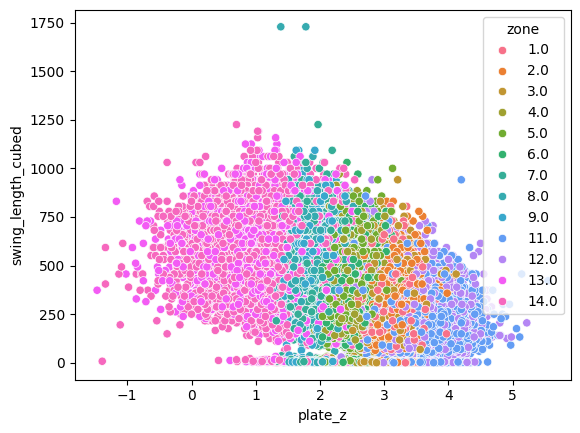

In [88]:
sns.scatterplot(df, x='plate_z',y='swing_length_cubed', hue='zone')
plt.show()

The lower the swing was vertically from the catcher's perspective when it crossed the plate the longer the swing length was. As the height of the pitch increased the swing lengths decreased. The relationship between the two, while present is not particularly strong. It is also appearent that the zone the pitch was thrown to relates to the the location of vertical location of the pitch. 

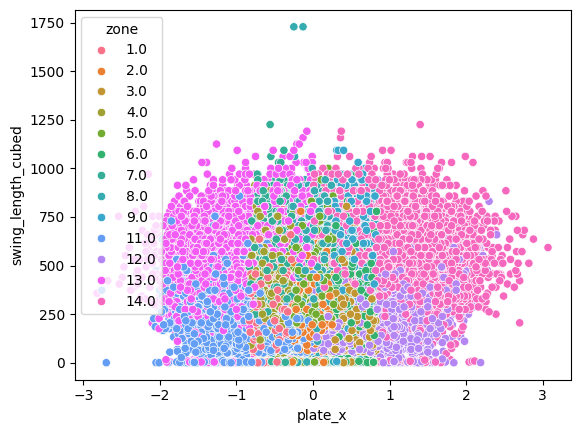

In [86]:
sns.scatterplot(df, x='plate_x',y='swing_length_cubed', hue='zone')
plt.show()

The horizontal location of the pitch is closely related to the zone the pitch was thrown to. There appears to be no strong linear relationship between swing length and the horizontal location of the pitch from the catcher's perspective when it crossed the plate. There does seem to be some relationship as shorter swings tend to happen closer to the center of the plate while shorter swings appear to occur on the edges close to -3 or 3. 

Since the zone of the pitch is determined by it's location within the batter's strike zone, there is a strong relationship between the zone and the horizontal and vertical location of the pitch when it crossed the plate. As such this variable will be dropped to removed redundant information.

In [100]:
df.drop(columns=['zone'], inplace=True)

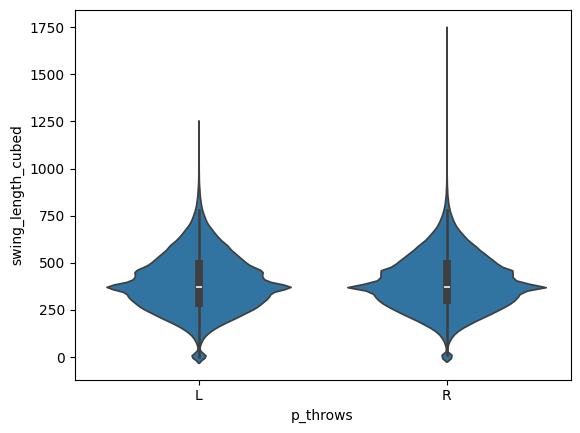

In [38]:
sns.violinplot(data=df, x='p_throws', y='swing_length_cubed')
plt.show()

There appears to be little difference in swing lengths against pitchers for either arm. Right arm pitchers have a longer tail most likely due to outliers. This makes sense as there are more right armed pitcher which increases the chances of outliers occuring for these pitchers. Since there is relatively little difference between the throwing arms, this feature will be dropped as it does not add useful information.

In [101]:
df.drop(columns=['p_throws'], inplace=True)

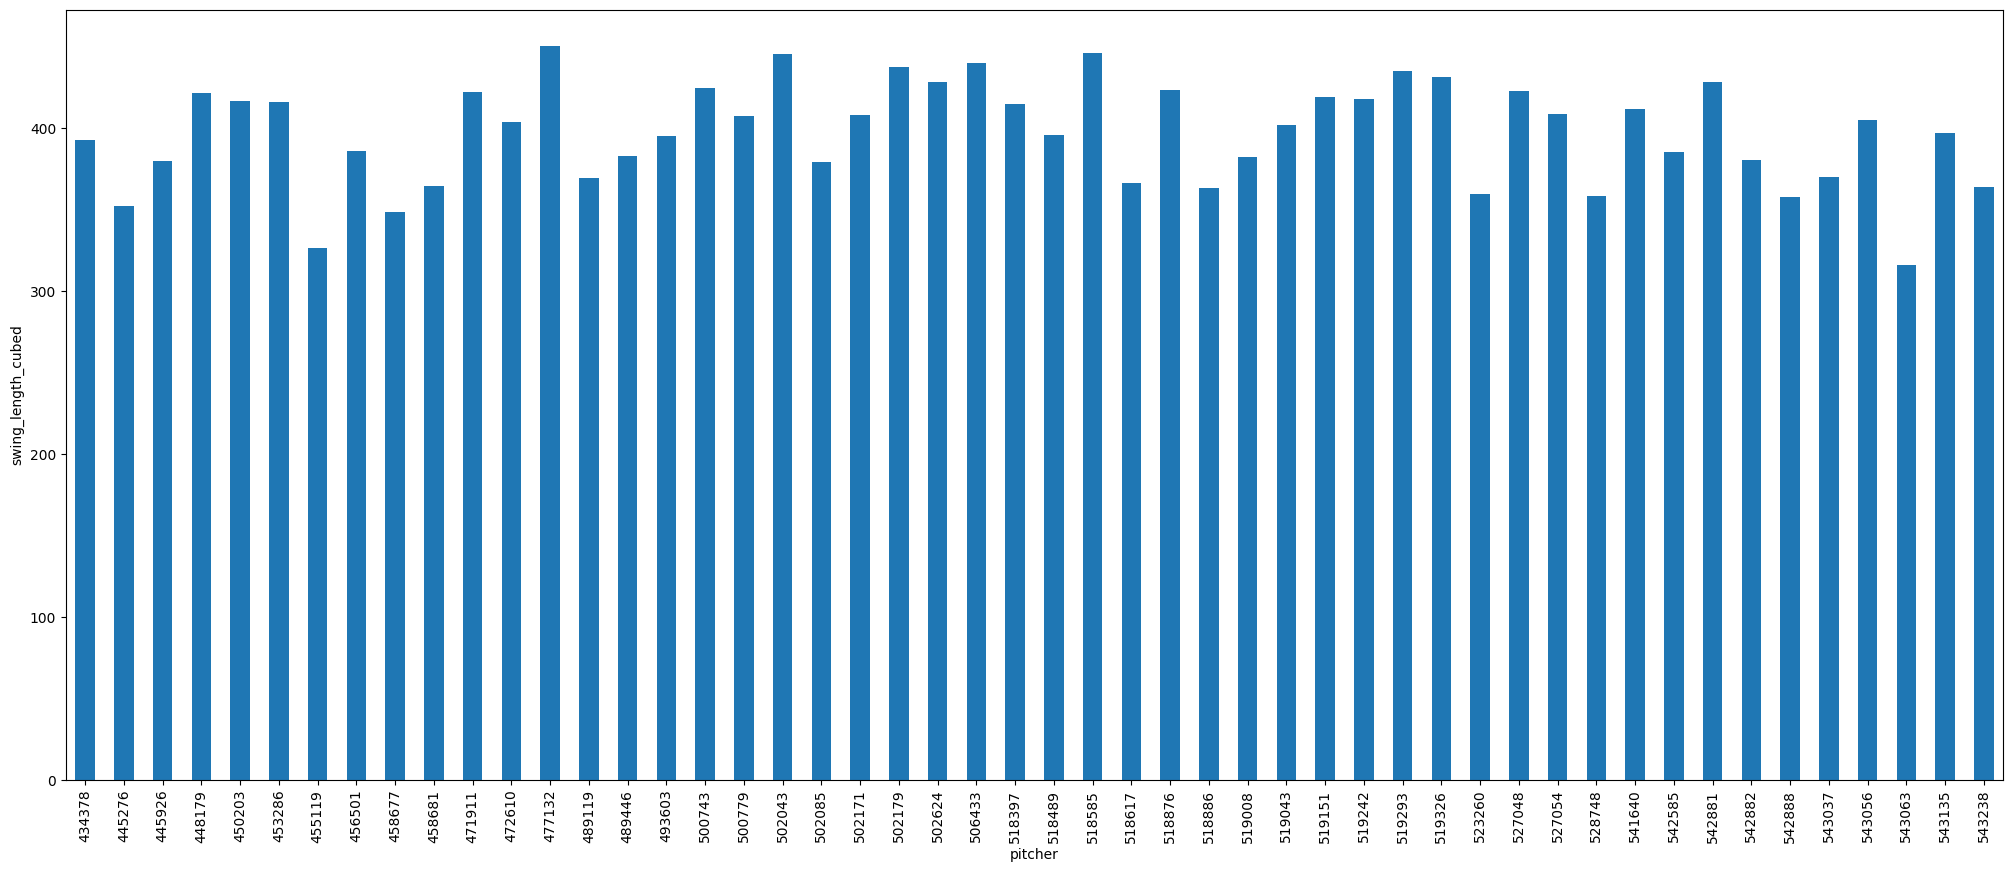

In [ ]:
pitchers = df.groupby('pitcher', observed=False)['swing_length_cubed'].mean()
pitchers[:50].plot(kind='bar', figsize=(25,10), ylabel='swing_length_cubed')
plt.show()

There does appear to be a difference in the average swing length against some pitchers. It can clearly be seen that the average swing length against pitcher 545121 is significantly shorter than the average swing length against most other pitchers. Similarly, the average swing length against pitcher 593833 are significantly longer than against other pitchers. This implies that there may be a relationship between pitcher themselves and the swing length.

In [72]:
corrs = df.corr(numeric_only=True)
corrs

release_speed     pfx_x     pfx_z   plate_x  \
release_speed                      1.000000 -0.290908  0.695872 -0.089385   
pfx_x                             -0.290908  1.000000 -0.196756  0.391102   
pfx_z                              0.695872 -0.196756  1.000000 -0.060374   
plate_x                           -0.089385  0.391102 -0.060374  1.000000   
plate_z                            0.407247 -0.079035  0.516859 -0.097329   
vx0                                0.161082 -0.553369  0.036736  0.111325   
vy0                               -0.999839  0.290128 -0.694451  0.090646   
vz0                               -0.566879  0.160290 -0.570900  0.001739   
ax                                -0.299110  0.982842 -0.184165  0.342975   
ay                                 0.821858 -0.234814  0.592308 -0.088135   
az                                 0.754514 -0.208220  0.986472 -0.063714   
effective_speed                    0.990983 -0.289701  0.689283 -0.086829   
spin_axis                          0.277617 -0.770281  0.285071 -0.304276   
api_break_z_with_gravity          -0.881550  0.241521 -0.934203  0.072716   
api_break_x_arm                    0.549531 -0.411730  0.452031 -0.207342   
swing_length_cubed                -0.409941  0.104124 -0.350168  0.126504   
release_spin_rate_yeojohnson      -0.057203  0.261281 -0.155553  0.145112   

                               plate_z       vx0       vy0       vz0  \
release_speed                 0.407247  0.161082 -0.999839 -0.566879   
pfx_x                        -0.079035 -0.553369  0.290128  0.160290   
pfx_z                         0.516859  0.036736 -0.694451 -0.570900   
plate_x                      -0.097329  0.111325  0.090646  0.001739   
plate_z                       1.000000  0.008510 -0.410487  0.204229   
vx0                           0.008510  1.000000 -0.161613 -0.037653   
vy0                          -0.410487 -0.161613  1.000000  0.565638   
vz0                           0.204229 -0.037653  0.565638  1.000000   
ax                           -0.078165 -0.666696  0.298447  0.148986   
ay                            0.358007  0.115353 -0.816999 -0.446872   
az                            0.498224  0.048536 -0.753055 -0.626298   
effective_speed               0.400740  0.166382 -0.991504 -0.561069   
spin_axis                     0.121616  0.221904 -0.276211 -0.168184   
api_break_z_with_gravity     -0.496280 -0.087871  0.881300  0.619149   
api_break_x_arm               0.184350  0.040241 -0.544236 -0.323445   
swing_length_cubed           -0.582627 -0.008868  0.411536 -0.038700   
release_spin_rate_yeojohnson  0.007147  0.031264  0.054770  0.103623   

                                    ax        ay        az  effective_speed  \
release_speed                -0.299110  0.821858  0.754514         0.990983   
pfx_x                         0.982842 -0.234814 -0.208220        -0.289701   
pfx_z                        -0.184165  0.592308  0.986472         0.689283   
plate_x                       0.342975 -0.088135 -0.063714        -0.086829   
plate_z                      -0.078165  0.358007  0.498224         0.400740   
vx0                          -0.666696  0.115353  0.048536         0.166382   
vy0                           0.298447 -0.816999 -0.753055        -0.991504   
vz0                           0.148986 -0.446872 -0.626298        -0.561069   
ax                            1.000000 -0.249201 -0.199765        -0.298144   
ay                           -0.249201  1.000000  0.656350         0.780971   
az                           -0.199765  0.656350  1.000000         0.746671   
effective_speed              -0.298144  0.780971  0.746671         1.000000   
spin_axis                    -0.705958  0.207881  0.284211         0.275952   
api_break_z_with_gravity      0.235690 -0.715543 -0.950323        -0.876188   
api_break_x_arm              -0.379103  0.458447  0.448113         0.536050   
swing_length_cubed            0.101220 -0.336204 -0.358652        -0.406413   
rel

There was some multicollinearity present in the data. The release_speed was highly correlated with effective_speed and vy0. Similarly, vy0 was highly correlated with the effective_speed. The acceleration of the pitch in the x-dimension, ax, was highly correlated with the horizontal movement of the pitch, pfx_x. Likewise, the acceleration of the pitch in the z-dimension, az, was also highly correlated with the vertical movement of the pitch, pfx_z. The vertical movement of the pitch was also correlated with the location of the pitch broke in the z-dimension. To avoid multicollinearity obscuring the relationship of other features to the target feature, release_speed, effective_speed, and pfx_x, and pfx_z were dropped from the dataset. 

In [20]:
df.drop(columns=['release_speed','effective_speed','pfx_x','pfx_z'], inplace=True)

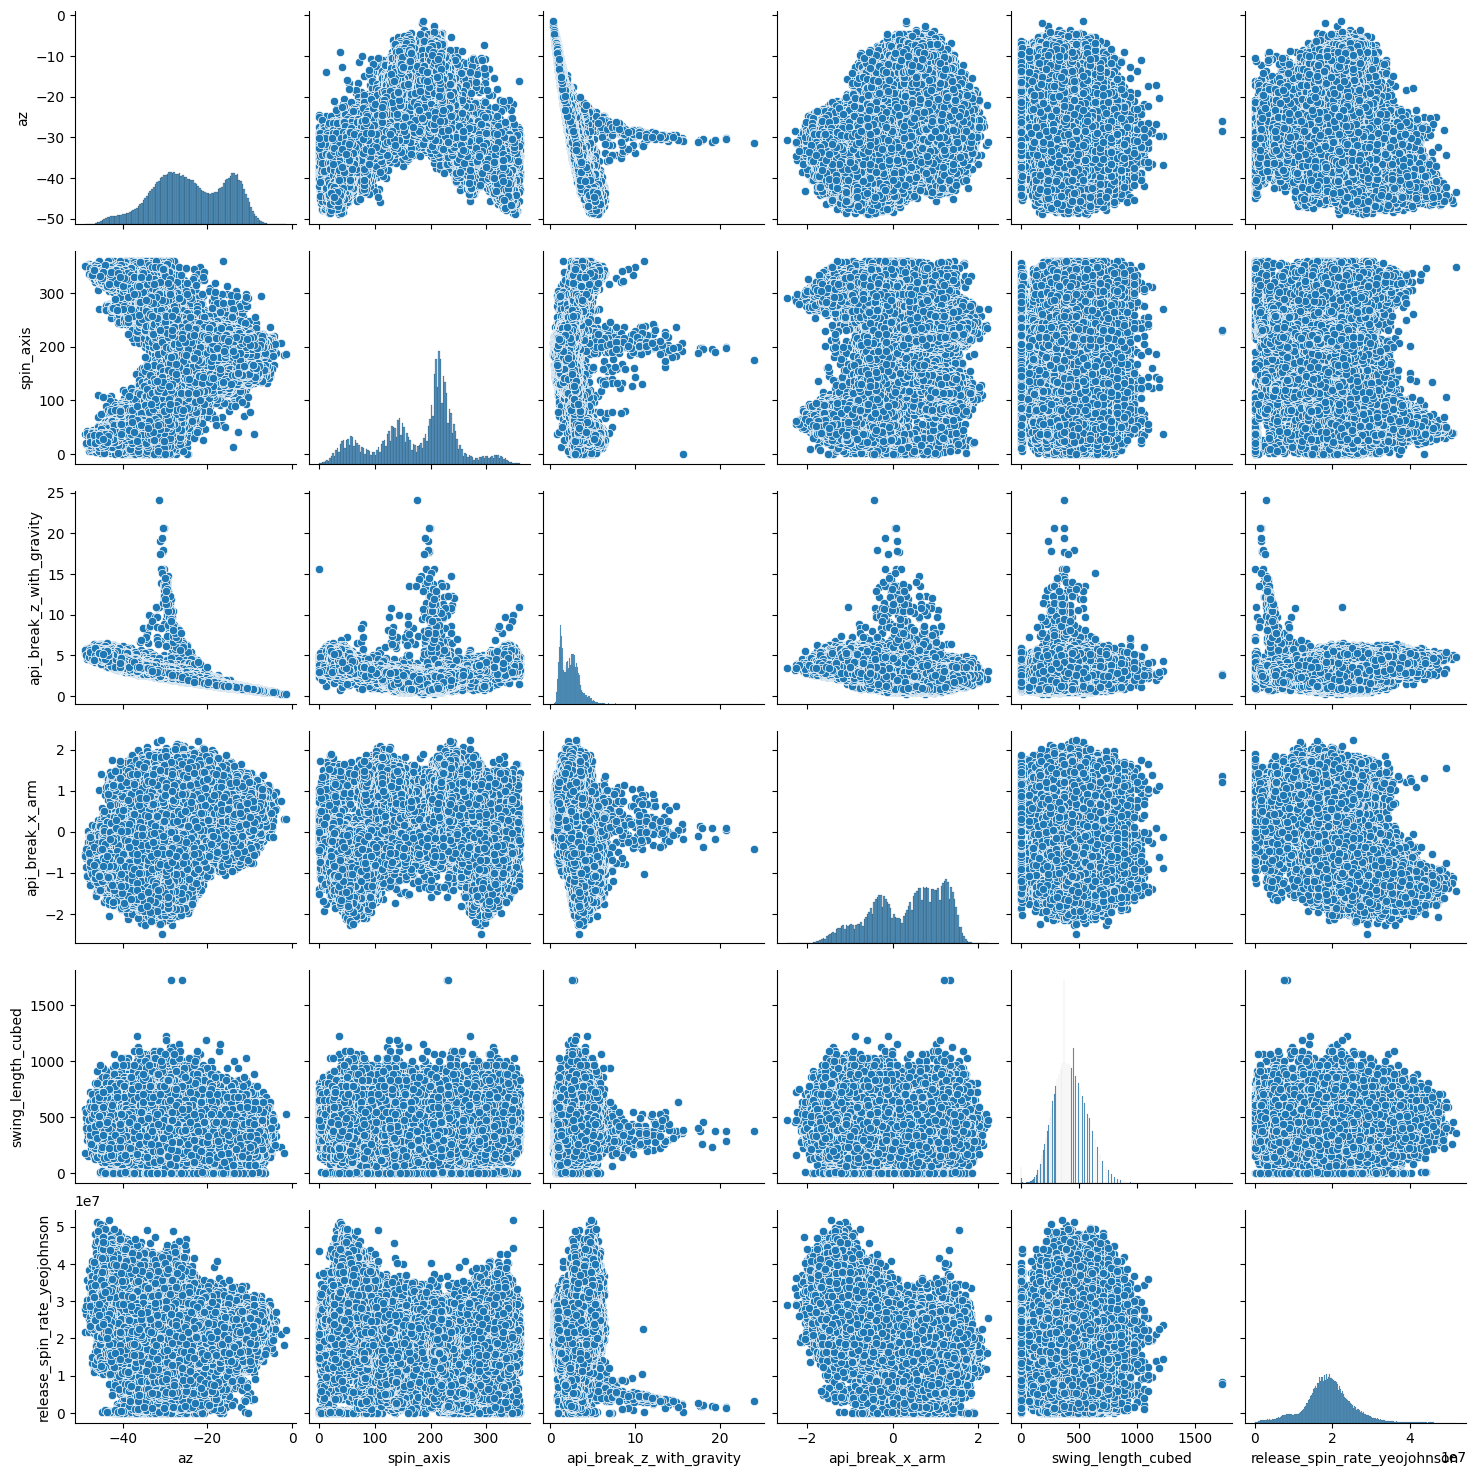

In [75]:
sns.pairplot(data=df.drop(columns=['pitcher', 'plate_x', 'plate_z', 
                                   'vx0', 'vy0','vz0', 'ax', 'ay']))
plt.show()

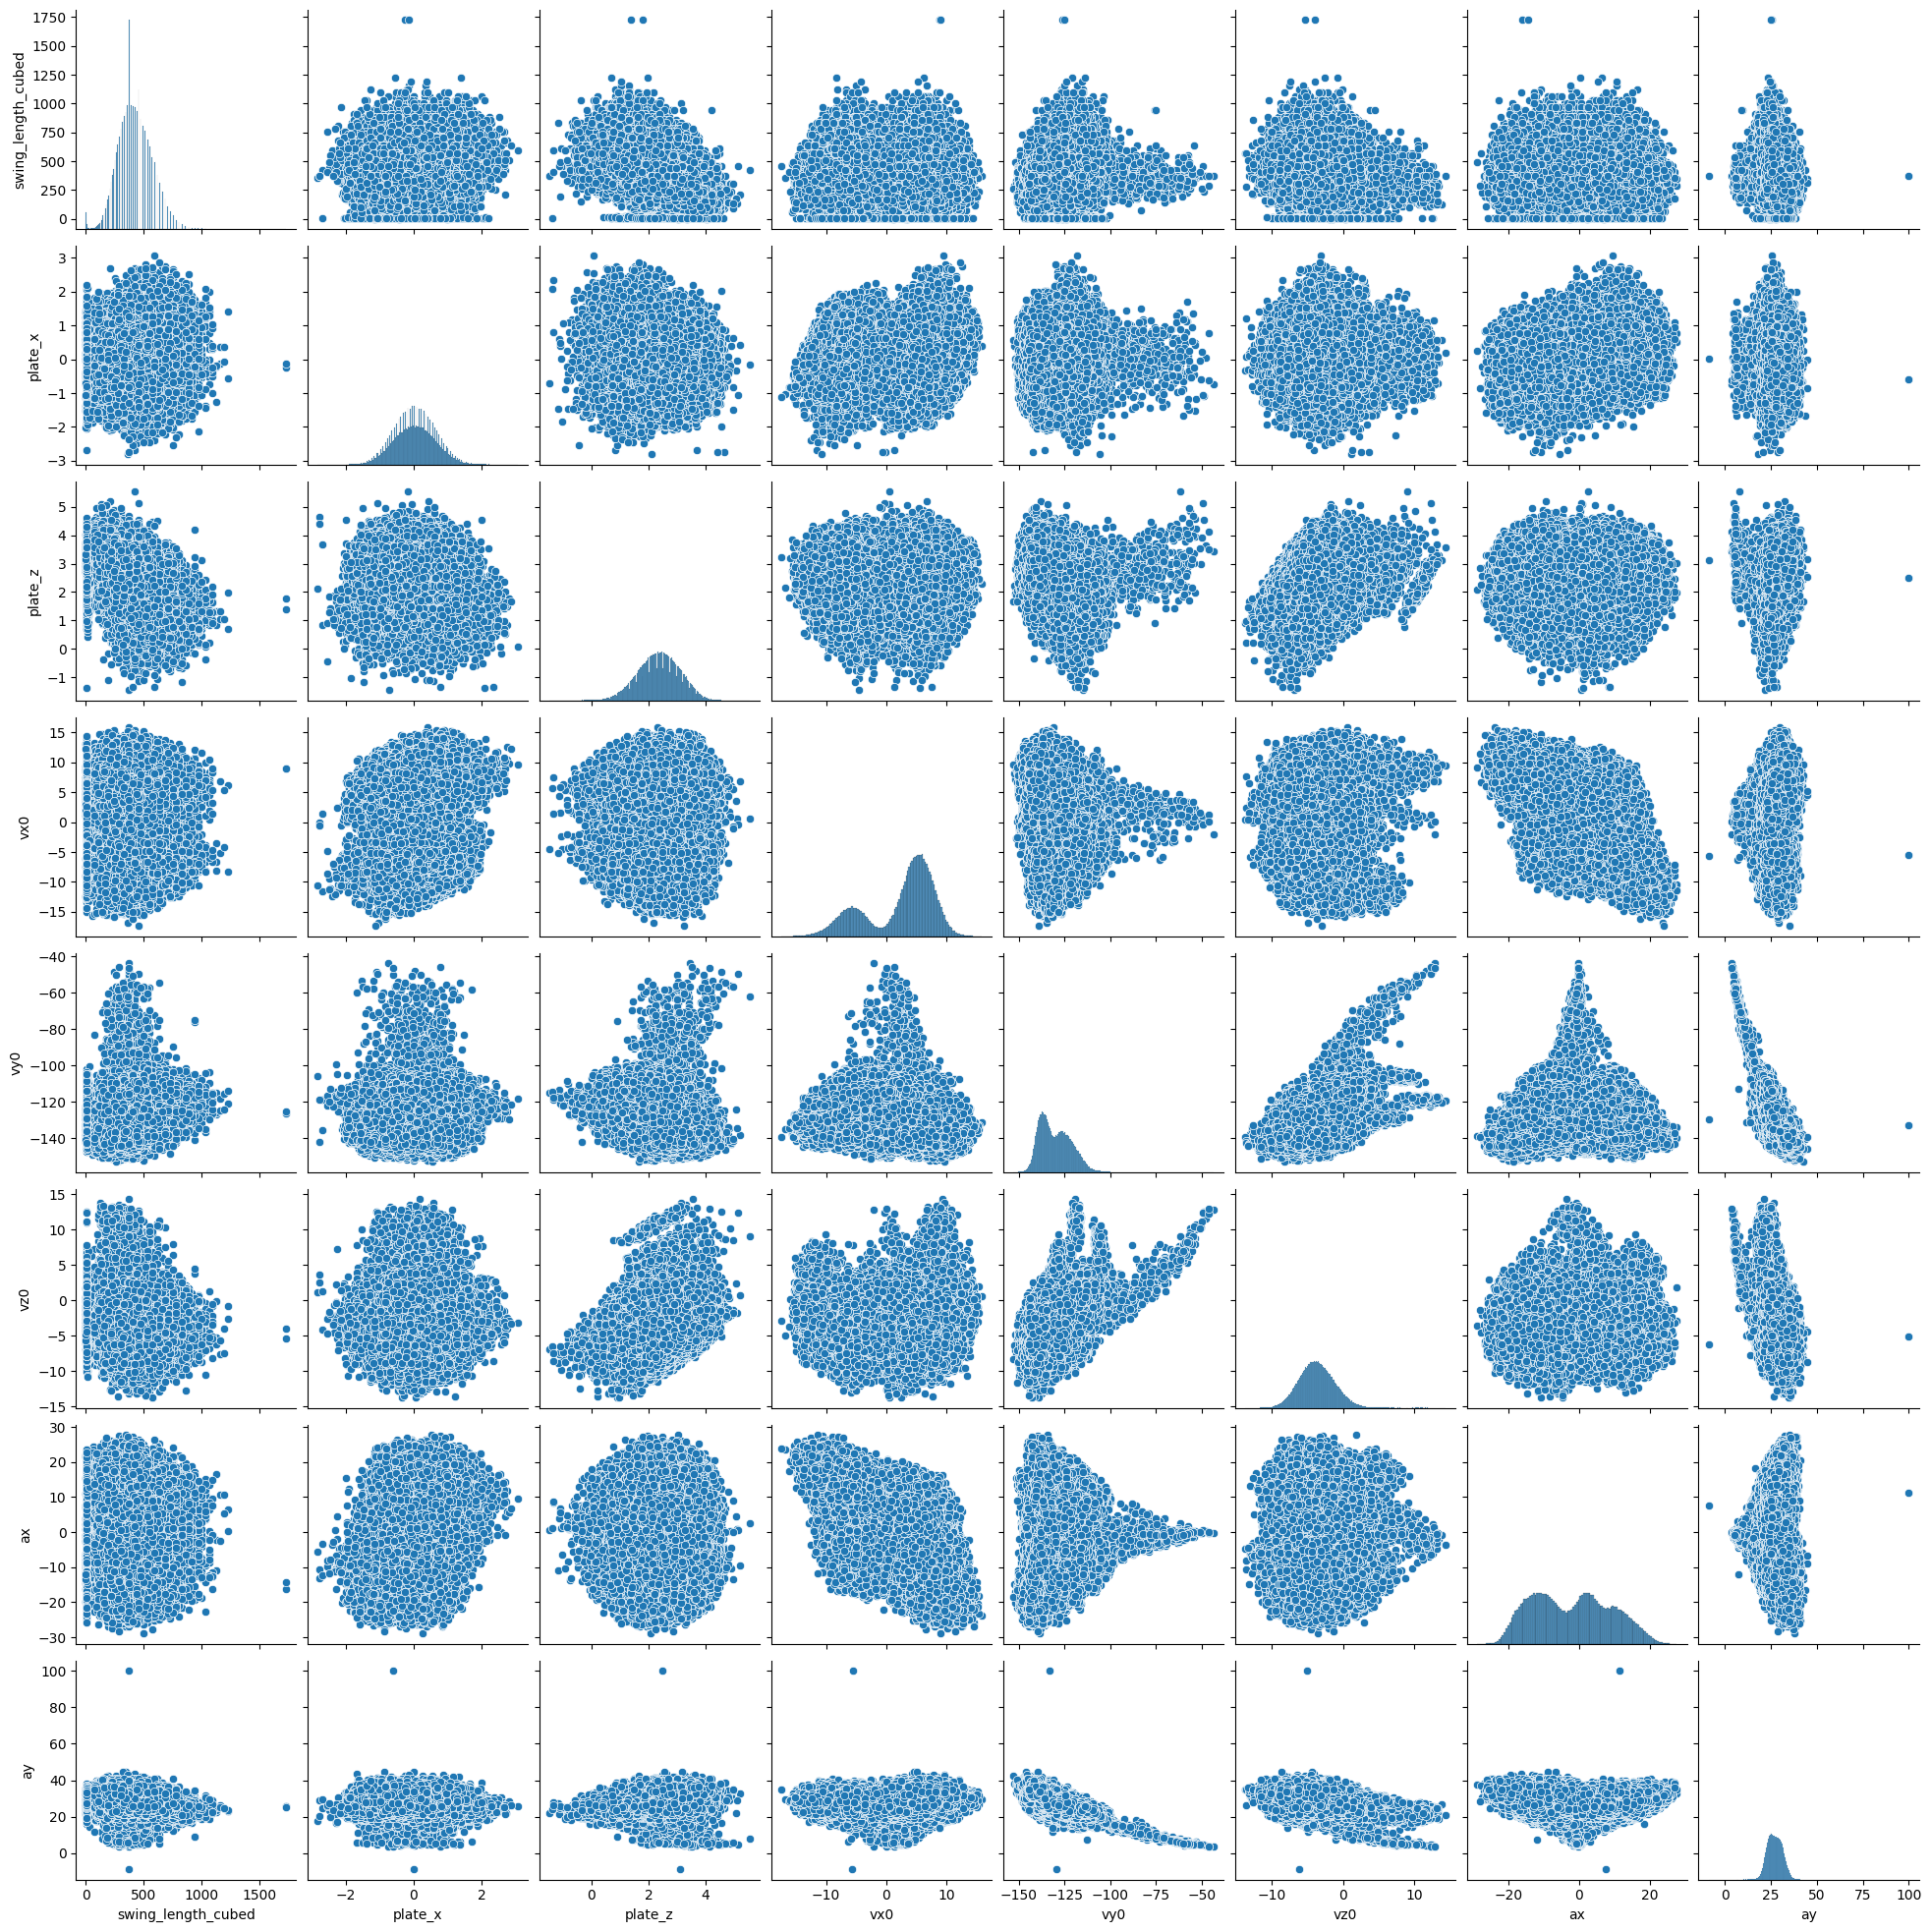

In [76]:
sns.pairplot(data=df[['swing_length_cubed','pitcher', 'plate_x',
                      'plate_z', 'vx0', 'vy0','vz0', 'ax', 'ay']])
plt.show()

As can be seen in the pairplots above, most of the input features do not have a linear relationships with the swing length. This suggests that linear models are likely unsuited for the data. Similarly, many of the features also appear not to have strong relationships with a batter's swing length. This can be seen in the correlation coefficients seen below. The highest correlation coefficient for an input feature and swing length is -0.583. There are seven input features with a correlation coefficient below +/- 0.01. 

In [78]:
corrs = df.corr(numeric_only=True)
targetCor = corrs.drop(['swing_length_cubed'])['swing_length_cubed']

targetCor.loc[targetCor.abs().sort_values(ascending= False).index]

plate_z                        -0.582627
vy0                             0.411536
api_break_z_with_gravity        0.389576
az                             -0.358652
ay                             -0.336204
api_break_x_arm                -0.211663
plate_x                         0.126504
spin_axis                      -0.125932
ax                              0.101220
vz0                            -0.038700
vx0                            -0.008868
release_spin_rate_yeojohnson    0.005658
Name: swing_length_cubed, dtype: float64

Due to the very low correlation scores with the swing length, the transformed release speed and the velocity in the x-dimension were dropped from the dataset. This was done to prevent the inclusion of features that do not add useful information to the analysis.

In [ ]:
df.drop(columns=['release_spin_rate_yeojohnson', 'vx0'],inplace=True)

### Feature Engineering

As previously noted, there appears to be a relationship between ceratin pitchers and the length of a batters' swings. There are 852 unique pitchers in the dataset and not all pitchers had a significant differece in the average swing length against them. To find the pitchers with the most significant impact on swing length, a linear regression was constructed. The ten most important pitchers were selected and added to the dataset as dummy variables. A pitcher's significance was determined by the coefficients from the regression.

In [ ]:
pitcher_df = df[['pitcher','swing_length_cubed']]
pitcher_df = pd.get_dummies(pitcher_df, dtype=int)

pitcher_reg = LinearRegression()
pitcher_reg.fit(pitcher_df.drop(columns=['swing_length_cubed']), pitcher_df['swing_length_cubed'])

LinearRegression()

In [ ]:
coeff_df = pd.DataFrame({'feature':pitcher_reg.feature_names_in_, 'coeff': pitcher_reg.coef_})
coeff_df.sort_values(by='coeff', key=abs, ascending=False, inplace=True)
coeff_df[:10]

feature       coeff
275  pitcher_641401  134.317761
746  pitcher_683021  124.452708
120  pitcher_593833  118.297136
331  pitcher_650671 -115.228178
221  pitcher_622065  114.888575
362  pitcher_656657 -112.326018
62   pitcher_545121 -110.278780
494  pitcher_666208  107.477783
792  pitcher_687847 -107.386007
762  pitcher_685314   97.619036

In [104]:
pitcher_df = pitcher_df[['pitcher_641401','pitcher_683021','pitcher_593833','pitcher_650671','pitcher_622065',
                     'pitcher_656657','pitcher_545121','pitcher_666208','pitcher_687847','pitcher_685314']]

df = pd.concat((df,pitcher_df), axis=1)
df.drop(columns=['pitcher'],inplace=True)

# Method
## Data Preprocessing
The training and test datasets were created using a 70% training and 30% test split. The datasets were shuffled and randomly split using sklearn's train_test_split() method. Since there was a large difference in the scales of each numerical feature, they were scaled to avoid features of larger scales overpowering other features. All numerical features were scaled using sklearn's StandardScaler. The scaling of features was done after the train-test split to avoid information leakage from the test data. All categorical features were one-hot encoded using sklearn's OneHotEncoder. 

In [105]:
X_train,X_test, Y_train, Y_test = train_test_split(df.drop(columns=['swing_length_cubed']),df['swing_length_cubed'], test_size=0.3, random_state=5280)

In [106]:
num_cols = ['plate_x','plate_z','vy0',
            'vz0','ax', 'ay','az','spin_axis', 
            'api_break_z_with_gravity','api_break_x_arm'
            ]
cat_pipe = make_pipeline(OneHotEncoder(handle_unknown="ignore"))
num_pipe = make_pipeline(StandardScaler())
preprocessor = ColumnTransformer([
    ('cat',cat_pipe, make_column_selector(dtype_include='category')),
    ('num', num_pipe, num_cols)], remainder='passthrough')

train_processed = preprocessor.fit_transform(X_train)

X_train_scaled = pd.DataFrame(train_processed, columns=preprocessor.get_feature_names_out())
X_train_scaled.columns = X_train_scaled.columns.str.removeprefix('cat__')
X_train_scaled.columns = X_train_scaled.columns.str.removeprefix('num__')
X_train_scaled.columns = X_train_scaled.columns.str.removeprefix('remainder__')

test_processed = preprocessor.transform(X_test)

X_test_scaled = pd.DataFrame(test_processed, columns=preprocessor.get_feature_names_out())
X_test_scaled.columns = X_test_scaled.columns.str.removeprefix('cat__')
X_test_scaled.columns = X_test_scaled.columns.str.removeprefix('num__')
X_test_scaled.columns = X_test_scaled.columns.str.removeprefix('remainder__')

## Modeling
To examine the role of the pitch and the pitcher on the batter's swing length, models were constructed to predict a batter's swing length. 4 baseline models were built as candidates for the final model. These baseline models were assessed on the average root mean squared error (RSME) and the average R-squared value from a 5-fold cross validation on the training data. The best performing model was the gradient boosted tree regression model which had an RSME of 110.137 and an R-squared of 0.407. From there, the gradient boosted tree was tuned to improve the performance using a combination of random searches and a grid search. The tuned model achieved an RSME of 109.665 and an R-squared of 0.414 on the test data. The low R-squared value implies that there are features that could explain more of the variance in swing lengths in addition to the properties of the pitch and the pitcher. 


### Baseline Models
As previously noted, most of the input features do not appear to have linear relationship with a batter's swing length. As such, the baseline models constructed for the analysis were limited to nonlinear models. The baseline models consisted of a K-nearest neighbor model, a regression decision tree, a regression random forest model, and a regression gradient boosted tree (XGBoost) model. All of the baseline models used the default settings for each model. The baseline K-nearest neighbor model used a k of 5 and the decision tree and random forest models were allowed to grow without limits. The gradient boosted tree model used a learning rate of 0.3, a max tree depth of 6, lambda for the l2 regularization of 1, and an alpha for the l1 regularization of 0. 


In [107]:
scores = {'RSME': 'neg_root_mean_squared_error',
           'R2': 'r2'}
knn = KNeighborsRegressor()
 
knn_cv = cross_validate(knn, X_train_scaled, Y_train, scoring=scores, cv=5)
knn_RMSE = -np.mean(knn_cv['test_RSME'])
knn_R2 = np.mean(knn_cv['test_R2'])

In [108]:
dTree = DecisionTreeRegressor(random_state=5280)

dTree_cv = cross_validate(dTree, X_train_scaled, Y_train, scoring=scores, cv=5)
dTree_RSME = -np.mean(dTree_cv['test_RSME'])
dTree_R2 = np.mean(dTree_cv['test_R2'])

In [109]:
rForest = RandomForestRegressor(random_state=5280)

rForest_cv = cross_validate(rForest, X_train_scaled, Y_train, scoring=scores, cv=5, n_jobs=5)
rForest_RSME = -np.mean(rForest_cv['test_RSME'])
rForest_R2 = np.mean(rForest_cv['test_R2'])

In [110]:
xgb = XGBRegressor(random_state=5280)

xgb_cv = cross_validate(xgb, X_train_scaled, Y_train, scoring=scores, cv=5, n_jobs=3)
xgb_RSME = -np.mean(xgb_cv['test_RSME'])
xgb_R2 = np.mean(xgb_cv['test_R2'])

In [111]:
metric_table = PrettyTable(['Model','Avg RSME','Avg R2'])
metric_table.add_row(['KNN Regressor',knn_RMSE, knn_R2])
metric_table.add_row(['Decision Tree', dTree_RSME, dTree_R2])
metric_table.add_row(['Random Forest', rForest_RSME, rForest_R2])
metric_table.add_row(['XGBoost Regressor',xgb_RSME, xgb_R2])
print(metric_table)

+-------------------+--------------------+----------------------+
|       Model       |      Avg RSME      |        Avg R2        |
+-------------------+--------------------+----------------------+
|   KNN Regressor   | 119.80675605156709 | 0.29887912368847136  |
|   Decision Tree   | 159.4634424856843  | -0.24211732717962714 |
|   Random Forest   | 111.5255416368612  |  0.3924594458334558  |
| XGBoost Regressor | 110.13668048294919 |  0.4074942803729157  |
+-------------------+--------------------+----------------------+


In [141]:
np.std(df['swing_length_cubed'])

np.float64(143.2207279721638)

Of the baseline models, the XGBoost regressor performed the best in the 5-fold cross validation with the highest average R-squared of 0.407 and the smallest average RMSE of 110.137. The random forest model performed the second best with an average RMSE of 111.526 and an average R-squared of 0.392. The decision tree performed the worst of all the models with an RMSE of 159.463, which is well above the 143.221 standard deviation of the cubed swing lengths. This implies that the model is worse than chance at predicting swing lengths. Similarly, it also had a negative R-squared value implying that the model does a poor job of explaining the variance of swing lengths. This suggests that the decision tree model is most likely severely overfit. As the best performing model from the cross-validation the XGBoost regressor was selected as the model for hyperparameter tuning. 

### Hyperparameter Tuning

To tune the XGBoost model, a combination of sklearn's RandomizedSearchCV and GridSearchCV was used. The purpose of using the RandomizedSearchCV and then the GridSearchCV was to go from more general ranges of values to very specific ranges of values. The first run of the RandomizedSearchCv indicated that some of the ranges for the hyperparameters were either too small or too large. In particular, the original search ranges for the number of estimators and the maximum number of leaves were too small. It took several rounds to find an appropriate range of values. The results of each run of the RandomizedSearchCV were used to more specific ranges of values for the next iteration. After the third iteration of the RandomizedSearchCV was completed, the ranges seemed to be specific enough to move to a GridSearchCV to find the exact values for the hyperparameters. The parameters tuned for the model were the number of estimators built by the model, the max depth for a tree, the max number of leaves for a tree, the learning rate, the alpha used for the l1 regularization, and lambda used for the l2 regularization. After the final round of tuning the best parameters were found to be 77 estimators, a max tree depth of 10, a maximum of 71 leaves, a learning rate of 0.1, an alpha of 1, and a lambda at 1. 

In [112]:
xgb = XGBRegressor(random_state=5280)

params = {
    'n_estimators': range(50,1001,50),
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'max_leaves': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'learning_rate': [0.1, 0.3, 0.5, 0.7, 0.9, 1, 1.1],
    'reg_alpha': [0.1, 0.3, 0.5, 0.7, 0.9, 1, 1.1, 1.2],
    'reg_lambda': [0.1, 0.3, 0.5, 0.7, 0.9, 1, 1.1, 1.2]
}

xgb_random = RandomizedSearchCV(xgb, params, n_iter=25, scoring='neg_root_mean_squared_error', random_state=5280, n_jobs=4)
xgb_random.fit(X_train_scaled, Y_train)
xgb_random.best_params_

{'reg_lambda': 1,
 'reg_alpha': 1,
 'n_estimators': 50,
 'max_leaves': 60,
 'max_depth': 10,
 'learning_rate': 0.1}

In [113]:
xgb = XGBRegressor(random_state=5280)

params = {
    'n_estimators': [45, 50, 55, 60, 65],
    'max_depth': [8, 9, 10, 11, 12, 13, 14, 15],
    'max_leaves': [54, 56, 58, 60, 62, 64, 66, 68, 70],
    'learning_rate': [0.02, 0.05, 0.1, 0.15, 0.2],
    'reg_alpha': [0.9, 0.92, 0.96, 0.98, 1, 1.02, 1.04, 1.06, 1.08],
    'reg_lambda': [0.9, 0.92, 0.96, 0.98, 1, 1.02, 1.04, 1.06, 1.08],
    
}

xgb_random = RandomizedSearchCV(xgb, params, n_iter=25, scoring='neg_root_mean_squared_error', random_state=5280, n_jobs=4)
xgb_random.fit(X_train_scaled, Y_train)
xgb_random.best_params_

{'reg_lambda': 0.98,
 'reg_alpha': 1,
 'n_estimators': 65,
 'max_leaves': 66,
 'max_depth': 8,
 'learning_rate': 0.15}

In [116]:
xgb = XGBRegressor(reg_alpha=1, random_state=5280)

params = {
    'n_estimators': [64, 66, 68, 70, 72, 74, 76],
    'max_depth': [6, 7, 8, 9, 10, 11],
    'max_leaves': [64, 65, 66, 67, 68, 69, 70, 71, 72],
    'learning_rate': [0.1, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19],
    'reg_lambda': [0.95, 0.96, 0.97, 0.98, 0.99, 1, 1.01]
}

xgb_random = RandomizedSearchCV(xgb, params, n_iter=30, scoring='neg_root_mean_squared_error', random_state=5280, n_jobs=4)
xgb_random.fit(X_train_scaled, Y_train)
xgb_random.best_params_

{'reg_lambda': 0.99,
 'n_estimators': 76,
 'max_leaves': 71,
 'max_depth': 10,
 'learning_rate': 0.1}

In [117]:
xgb = XGBRegressor(reg_alpha=1, random_state=5280)

params = {
    'n_estimators': [74, 75, 76, 77, 78],
    'max_leaves': [66, 68, 70, 71, 72],
    'max_depth': [8, 9, 10],
    'learning_rate': [0.1, 0.15],
    'reg_lambda': [0.98, 0.99, 1]
}

xgb_grid = GridSearchCV(xgb,params,scoring='neg_root_mean_squared_error', n_jobs=3)
xgb_grid.fit(X_train_scaled, Y_train)
xgb_grid.best_params_

{'learning_rate': 0.1,
 'max_depth': 10,
 'max_leaves': 71,
 'n_estimators': 77,
 'reg_lambda': 1}

## Evaluating the Final Model

In [118]:
final_model = XGBRegressor(n_estimators=71, 
                           max_depth=10, 
                           max_leaves=71, 
                           learning_rate=0.1,
                           reg_alpha=1,
                           reg_lambda=1, 
                           random_state=5280)
final_model.fit(X_train_scaled, Y_train)

preds = final_model.predict(X_test_scaled)

print(f'Final model RSME: {root_mean_squared_error(Y_test, preds)}')
print(f'Final model R2: {r2_score(Y_test,preds)}')

Final model RSME: 109.66491868751449
Final model R2: 0.4141157370936396


The final tuned model had a testing RMSE of 109.665, well below the standard deviation of the cubed swing lengths. This implies that the model does a better job than random chance at predicting swing lengths. The model had a final R-squared score of 0.414, which implies that only about 41% of variance in swing lengths was explained by the model. Using only features that relate to attributes of the pitch or who threw the pitch does a less than impressive job of predicting swing lengths. This suggests that other features were not considered in the model that may explain more of the variance in the length of a swing. These could include how far back a batter was standing in the batter's box or external factors such as if there was a runner on base or if the in-fielders were in closer. Since baseball is as much a game of strategy as a game skill, it is unlikely that a model that excludes external factors that influence strategy will have much success.

# Analysis

To analyze whether the pitcher or the aspects of the pitcher were more important in predicting the swing length, the permuted feature importance scores were computed. The permuted feature importance was used over the feature importance from the model as it counteracts the bias towards high cardinality features of tree-based models. It also measures the decrease in RMSE over the decrease in purity. Overall, permuted feature importance is a more robust way of determining feature importance in the model and as such was the preferred method for this analysis.

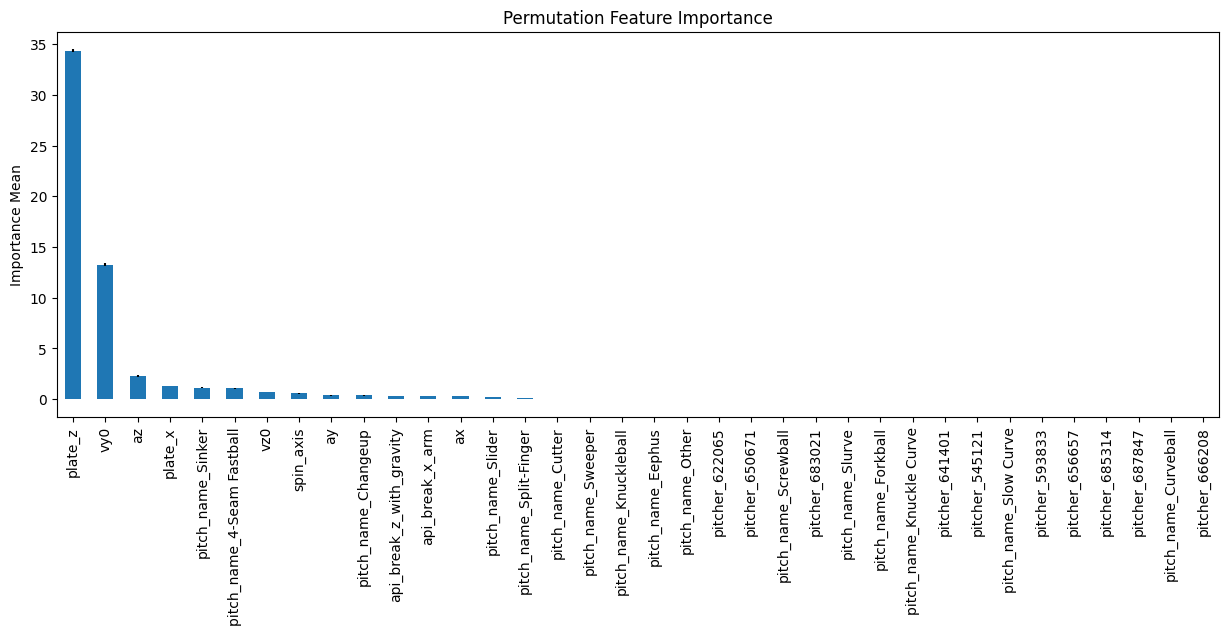

In [120]:
perm_import = permutation_importance(final_model, X_test_scaled, Y_test, scoring='neg_root_mean_squared_error', n_jobs= 3, random_state=5280)
importance = pd.DataFrame({"importance_mean": perm_import["importances_mean"],"importance_std": perm_import["importances_std"]}, index=final_model.feature_names_in_)
importance.sort_values(by='importance_mean', ascending=False, inplace=True)
# plot feature importance
importance["importance_mean"].plot(figsize=(15, 5), kind="bar", yerr=importance["importance_std"])
plt.title("Permutation Feature Importance")
plt.ylabel("Importance Mean")
plt.show()

In [121]:
importance

importance_mean  importance_std
plate_z                           34.369534        0.139044
vy0                               13.243019        0.160543
az                                 2.321369        0.092990
plate_x                            1.288389        0.041993
pitch_name_Sinker                  1.135359        0.052351
pitch_name_4-Seam Fastball         1.073919        0.046433
vz0                                0.704756        0.029786
spin_axis                          0.567665        0.028417
ay                                 0.395230        0.036643
pitch_name_Changeup                0.364828        0.011173
api_break_z_with_gravity           0.322535        0.010910
api_break_x_arm                    0.285979        0.025287
ax                                 0.282462        0.019511
pitch_name_Slider                  0.226915        0.011428
pitch_name_Split-Finger            0.117470        0.012613
pitch_name_Cutter                  0.034814        0.006123
pitch_name_Sweeper                 0.029161        0.004120
pitch_name_Knuckleball             0.006336        0.001443
pitch_name_Eephus                  0.001954        0.000310
pitch_name_Other                   0.001916        0.001541
pitcher_622065                     0.001419        0.001615
pitcher_650671                     0.001009        0.000479
pitch_name_Screwball               0.000705        0.000712
pitcher_683021                     0.000518        0.000000
pitch_name_Slurve                  0.000425        0.000124
pitch_name_Forkball                0.000237        0.001155
pitch_name_Knuckle Curve           0.000228        0.000248
pitcher_641401                     0.000136        0.000063
pitcher_545121                     0.000000        0.000000
pitch_name_Slow Curve              0.000000        0.000000
pitcher_593833                     0.000000        0.000000
pitcher_656657                     0.000000        0.000000
pitcher_685314                     0.000000        0.000000
pitcher_687847                     0.000000        0.000000
pitch_name_Curveball              -0.000714        0.000584
pitcher_666208                    -0.000718        0.000359

The majority of features used in the model were unimportant with 21 input features having an average feature importance of less than 0.01. This included all of the created pitcher dummy variables, implying that the pitchers themselves were not an important factor in predicting swing length for the model. This suggests that based on the model there is not a strong argument in favor of the pitcher dictating a batter's swing. This does not account for other factors such as the pitcher's stance, pitching form, or other factors that the pitch can control. This may be an area of future research into whether a pitcher's stance or pitching form rather than the pitcher individually can dictate a batter's swing. 

Another interesting trend in the feature importance is the importance of the location of the pitch. The most important feature by far in predicting the length of a swing for the model was the plate_z feature or the vertical position of the ball when it crossed the plate from the catcher's perspective. As seen in the exploratory data analysis, there was a downward trend in the swing lengths as the vertical position of the ball increases. This makes sense as the swing length is the sum of all movement in the x, y, and z-dimensions, and lower balls require more movement to hit than higher balls. This trend can also be seen in the fact that the sinker pitch also had high importance. Sinker pitches tend to sink low and thus influence the hit of the ball at the plate. The fourth most important feature was plate_x or the horizontal position of the ball when it crossed the plate from the catcher's. This is interesting as from the exploratory data analysis it was clear that there was no strong linear relationship between plate_x and the swing length. However, it did appear that the longer swings tended to occur in the middle range of the horizontal position. The implication of this is that the location of the pitch is more influential in predicting the swing length than most other features.

A third interesting trend was the importance of the speed of a pitch. Whether a pitch was a fastball or a changeup, which effects the speed of the pitch, were both important features. Similarly, the acceleration of the pitch in all dimensions was important with the acceleration in the z-dimension being the third most important feature in the model. This implies that the speed of a pitch is important in predicting the length of a swing. With the fastball being one of the more important features, it is likely that the faster the pitch is, the greater the influence on the swing length. This could be due to the shorter amount of time the batter has to swing the bat before the pitch arrives at the plate. This is a place for further exploration in another analysis.


# Summary
This analysis sought to answer the question of whether a pitch dictates a batter's swing, and if so, to what extent is that the result of the pitcher or the pitch. Four candidate models were constructed to predict the length of a swing. These candidate models included a K-nearest neighbor model, a regression decision tree, a regression random forest model, and a gradient boosted tree model. The best performing model was the gradient boosted tree model, which was subsequently tuned to improve its performance. Overall, the model only achieved a test R-square score of 0.414, which was a sub-par performance. This implies that other features besides the aspects of the pitch and who threw the pitch will likely do a better job of explaining the variance in swing lengths.

Based on the model, the aspects of the pitch were found to be more important than the pitcher in predicting swing lengths. The most important features of the model tended to be those that involved the location of the pitch when it crossed the plate. The most important feature in the model was the vertical position of the ball when it crossed the plate from the catcher's perspective. The horizontal position of the pitch was also found to have high importance in predicting swing lengths. The suggestion is that the location of the pitch may influence the length of the swing. For example, lower pitches may require more vertical movement of the bat to connect with the ball, leading to longer swings. The speed of the pitch, particularly the velocity and the acceleration of the pitch, were also found to be important. This may be due to faster pitches leaving less time for the batter to swing, causing swing lengths to be shorter. The exact effects of this relationship may be a further area of research.  Another interesting trend is that none of the features representing a pitcher were important for the model. This implies that the pitcher individually likely has little influence over the length of a swing.  Rather, their pitch had a greater influence over the batter’s swing.

# Further Research
The scope of this analysis was limited to just the effects of the pitch and the pitcher on the swing length. It did not include other features that may influence the length of swing, which could provide interesting avenues for further research. This study could be enhanced by including strategic elements in the analysis to see if the pitch or the strategic considerations have more of an influence on the batter’s swing. This may include data such as if a runner was on base, the score before the pitch, or even the number of strikes against the batter. Additionally, features such as the position of the in-fielders and out-fielders could be interesting to examine as well. One area for further research would be the inverse of this study, to see whether the pitch or the pitcher can influence whether or not a batter swings at the ball. Another area of future research could be how much control the batter has over their swing length. This could examine measurements such as where the batter was standing in the batting box, which side they bat, or even their physical characteristics such as height or wingspan. 

# Citations
Baseball Savant. <i>Statcast Search CSV Documentation.</i> https://baseballsavant.mlb.com/csv-docs.

Statcast (2024). <i>statcast_pitch_swing_data_20240402_20241030_with_arm_angle2</i> [Data set]. CSAS. 
    https://statds.org/events/csas2025/challenge.html

